In [45]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [47]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [52]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [54]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

/var/folders/4l/dr4_xsp56d91b69fgj8_g7880000gn/T/ipykernel_9592/3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [56]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [58]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [60]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [63]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

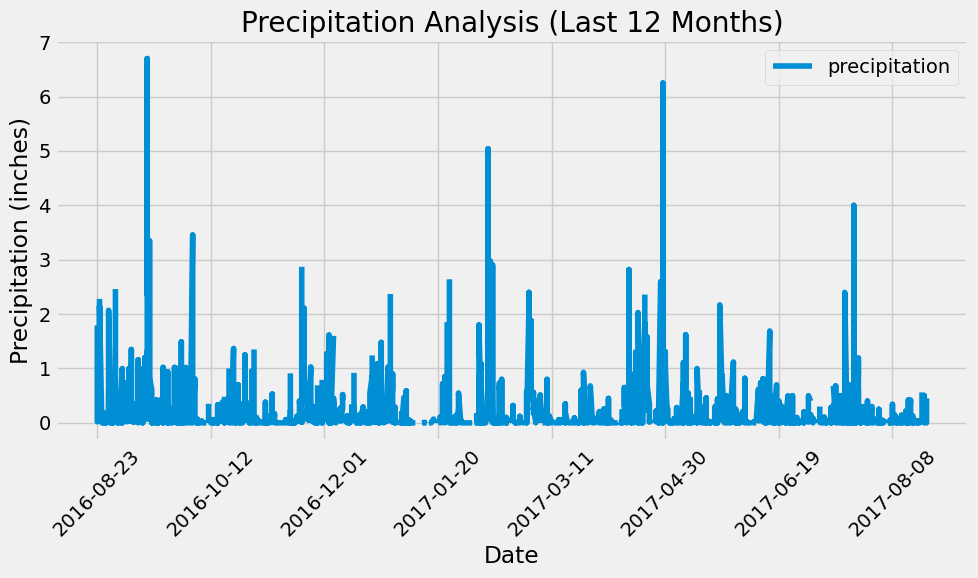

In [91]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = pd.to_datetime(most_recent_date) 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Format dates as strings
most_recent_date_str = most_recent_date.strftime('%Y-%m-%d')
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
                 .filter(Measurement.date >= one_year_ago_str)\
                 .filter(Measurement.date <= most_recent_date_str)\
                 .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['prcp'], label='precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Analysis (Last 12 Months)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) 
plt.legend()
plt.tight_layout()
plt.show()


In [115]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['prcp'].describe()
# Create a DataFrame to display summary statistics in a table format
summary_table = pd.DataFrame(summary_stats)
summary_table = summary_table.rename(columns={'prcp': 'Precipitation'})

# Display the summary statistics table
display(summary_table)

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [117]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Station.station))).scalar()
total_stations

9

In [80]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc())\
                         .all()
for station, count in active_stations:
    print(f"Station ID: {station}, Observations: {count}")

Station ID: USC00519281, Observations: 2772
Station ID: USC00519397, Observations: 2724
Station ID: USC00513117, Observations: 2709
Station ID: USC00519523, Observations: 2669
Station ID: USC00516128, Observations: 2612
Station ID: USC00514830, Observations: 2202
Station ID: USC00511918, Observations: 1979
Station ID: USC00517948, Observations: 1372
Station ID: USC00518838, Observations: 511


In [82]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


# Find the most active station (assuming you have the station ID from previous query)
most_active_station = session.query(Measurement.station, func.count(Measurement.station))\
                             .group_by(Measurement.station)\
                             .order_by(func.count(Measurement.station).desc())\
                             .first()[0]

# Query to calculate lowest, highest, and average temperature at the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
                           .filter(Measurement.station == most_active_station)\
                           .all()

# Extracting results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature Recorded: {lowest_temp} °F")
print(f"Highest Temperature Recorded: {highest_temp} °F")
print(f"Average Temperature Recorded: {avg_temp:.2f} °F")

Most Active Station ID: USC00519281
Lowest Temperature Recorded: 54.0 °F
Highest Temperature Recorded: 85.0 °F
Average Temperature Recorded: 71.66 °F


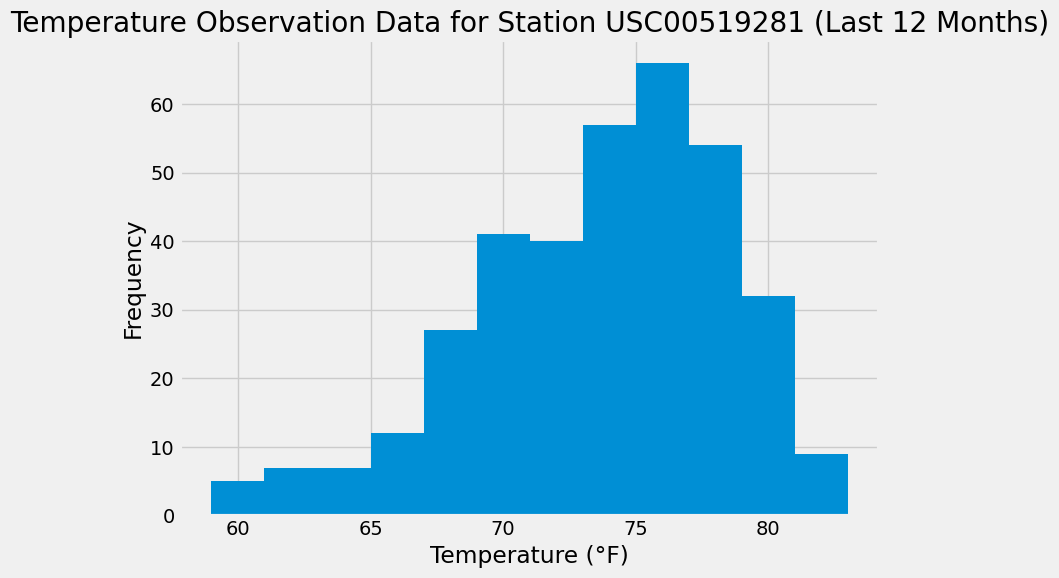

In [84]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .first()[0]

# Find the most recent date and calculate last 12 months
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
most_recent_date = pd.to_datetime(most_recent_date)
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Convert dates to string format
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
most_recent_date_str = most_recent_date.strftime('%Y-%m-%d')

# Query to retrieve temperature data for the last 12 months for the most active station
results = session.query(Measurement.date, Measurement.tobs)\
                 .filter(Measurement.station == most_active_station_id)\
                 .filter(Measurement.date >= one_year_ago_str)\
                 .filter(Measurement.date <= most_recent_date_str)\
                 .all()

# Convert query results to DataFrame
df = pd.DataFrame(results, columns=['date', 'tobs'])

# Plot histogram of TOBS data
plt.figure(figsize=(8, 6))
plt.hist(df['tobs'], bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station_id} (Last 12 Months)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [87]:
# Close Session
session.close()
